# AI Training For Fertilizer v.s Tap

In [1]:
import torch
from torch import nn
import numpy as np
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from tqdm import tqdm

## Building Model

In [2]:
class ConvLayer(nn.Module):
    def __init__(self, inputChannels, outputChannels):
        super().__init__()
        self.ConvLayer = nn.Sequential(
            nn.Conv2d(in_channels=inputChannels, out_channels=outputChannels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1, stride=1)
        )

    def forward(self, x: torch.Tensor):
        return self.ConvLayer(x)



class Model(nn.Module):
    
    
    def __init__(self, in_channels: int, hidden_channels: int, hidden_layers:int, out_channels: int, height: int, width: int):
        super().__init__()
        
        num = (height/(hidden_layers*2))*(width/(hidden_layers*2))

        self.input = nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, padding=1, stride=1)
        self.conv_layers = nn.ModuleList()
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=out_channels),
            nn.Sigmoid()
        )

        for i in range(hidden_layers):
            self.conv_layers.append(ConvLayer(inputChannels=hidden_channels, outputChannels=hidden_channels))



    def forward(self, X: torch.Tensor):
        X = self.input(X)

        for layer in self.conv_layers:
            X = layer(X)

        return self.output(X)

## Loading Data and Transforming

In [3]:
transform = transforms.Compose([transforms.Resize(size=(640,480)), transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5), transforms.RandomRotation(degrees=(0,360)), transforms.ToTensor()])

dataset = datasets.ImageFolder(root="data", transform=transform)

## Hyperparameters

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print( torch.cuda.is_available())
BATCH_SIZE=16
LEARNING_RATE=0.001
NUM_WORKERS=4
EPOCHS = 10
MODEL_NAME = "First Trial"

#Create Schedularer

model = Model(in_channels=3, hidden_channels=10, hidden_layers=3, out_channels=3, height=480, width=640)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=LEARNING_RATE, params=model.parameters())

True


## Accuracy Function and Visualization

In [5]:
def acc(preds, y):
    preds=torch.argmax(preds, dim=1)
    correct = torch.eq(y, preds).sum().item()
    acc = (correct / len(preds)) * 100
    return acc

def plot_loss(num_of_epochs, vals, title, y_axis):
    epoch_list = range(num_of_epochs)
    for i in vals:
        plt.plot(epoch_list, i)
    plt.xlabel('Epochs')
    plt.ylabel(y_axis)
    plt.title(title)
    plt.savefig(f"{title}.png")
    plt.clf()

## Training and Testing

In [6]:
kfold= KFold(n_splits=5, shuffle=True, random_state=42)

global_training_loss, global_training_acc, global_val_loss, global_val_acc =[],[],[],[]


model.to(device=DEVICE)
print(f"\nTraining started on {DEVICE}\n")

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    torch.cuda.empty_cache()

    training_loss, val_loss, training_acc, val_acc = 0,0,0,0
    training_loss_vals, training_acc_vals, val_loss_vals, val_acc_vals = [], [], [], []
    
    training_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)

    train_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
    val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

    model.train()
    for epoch in (range(EPOCHS)):
        for X, y in tqdm(train_loader, leave=True):
            X, y = X.to(device=DEVICE), y.to(device=DEVICE)
            preds = model(X)
            #preds=preds.argmax(dim=1)
            #preds = preds.to(torch.uint8)
            #print(preds)
            loss = loss_function(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss+=loss.item()
            training_acc+=acc(preds=preds, y=y)


        training_loss /= len(train_loader)
        training_acc /= len(train_loader)

        training_loss_vals.append(training_loss)
        training_acc_vals.append(training_acc)
    
        with torch.inference_mode():
            model.eval()
            for X, y in val_loader:
                X, y = X.to(device=DEVICE), y.to(device=DEVICE)
                preds = model(X)
                loss = loss_function(preds, y)
                val_loss+=loss.item()
                val_acc+=acc(preds=preds, y=y)

            val_loss /= len(val_loader)
            val_acc /= len(val_loader)

            val_loss_vals.append(val_loss)
            val_acc_vals.append(val_acc)

        print(f"\nEpoch {epoch} finished with training loss: {training_loss}, testing loss: {val_loss}, training accuracy: {training_acc}, testing accuracy: {val_acc}\n")
    
    plot_loss(num_of_epochs=EPOCHS, vals=training_loss_vals, y_axis="Loss", title=f"Fold #{fold} Training Loss")
    plot_loss(num_of_epochs=EPOCHS, vals=training_acc_vals, y_axis="Accuracy", title=f"Fold #{fold} Training Accuracy")
    plot_loss(num_of_epochs=EPOCHS, vals=val_loss_vals, y_axis="Loss", title=f"Fold #{fold} Validation Loss")
    plot_loss(num_of_epochs=EPOCHS, vals=val_acc_vals, y_axis="Accuracy", title=f"Fold #{fold} Validation Loss")

    global_training_loss.append(training_loss)
    global_training_acc.append(training_acc)
    global_val_loss.append(val_loss)
    global_val_acc.append(val_acc)
    
    print(f"Fold #{fold} Completed")

print(f"Global Training Losses = {global_training_loss}\nGlobal Training Accuracy = {global_training_acc}\nGlobal Validation Loss = {global_val_loss}\nGlobal Validation Accuracy = {global_val_acc}")
torch.save(obj=model.state_dict(), f=MODEL_NAME)




Training started on cuda



100%|██████████| 1377/1377 [15:55<00:00,  1.44it/s]



Epoch 0 finished with training loss: 0.787873165669784, testing loss: 0.7860463366992232, training accuracy: 76.33805374001453, testing accuracy: 76.53985507246377



100%|██████████| 1377/1377 [13:51<00:00,  1.66it/s]



Epoch 1 finished with training loss: 0.7882280403527578, testing loss: 0.7883247318780614, training accuracy: 76.43434136074075, testing accuracy: 76.76170972484772



100%|██████████| 1377/1377 [13:51<00:00,  1.66it/s]



Epoch 2 finished with training loss: 0.7882010648059367, testing loss: 0.7883313359220581, training accuracy: 76.43713459793808, testing accuracy: 76.76235278181115



100%|██████████| 1377/1377 [13:51<00:00,  1.66it/s]



Epoch 3 finished with training loss: 0.7882282770933443, testing loss: 0.7883313550642147, training accuracy: 76.43441331488594, testing accuracy: 76.76235464574438



100%|██████████| 1377/1377 [14:32<00:00,  1.58it/s] 



Epoch 4 finished with training loss: 0.7882010642420018, testing loss: 0.7883313551196991, training accuracy: 76.43713465019236, testing accuracy: 76.76235465114708



100%|██████████| 1377/1377 [13:50<00:00,  1.66it/s]



Epoch 5 finished with training loss: 0.7882010449990129, testing loss: 0.78833135511986, training accuracy: 76.43713662647072, testing accuracy: 76.76235465116274



100%|██████████| 1377/1377 [13:49<00:00,  1.66it/s]



Epoch 6 finished with training loss: 0.7883099777325987, testing loss: 0.7883313551198604, training accuracy: 76.42624338171856, testing accuracy: 76.76235465116278



100%|██████████| 1377/1377 [13:49<00:00,  1.66it/s]



Epoch 7 finished with training loss: 0.7882555884114786, testing loss: 0.7883313551198604, training accuracy: 76.43168209395913, testing accuracy: 76.76235465116278



100%|██████████| 1377/1377 [13:49<00:00,  1.66it/s]



Epoch 8 finished with training loss: 0.7882555509042112, testing loss: 0.7883313551198604, training accuracy: 76.43168604364122, testing accuracy: 76.76235465116278



 41%|████      | 563/1377 [05:48<08:24,  1.61it/s]


KeyboardInterrupt: 

In [7]:
from PIL import Image
img = Image.open("data/clean/Clean Tap 2_image_0.png")
    
tran = transforms.Compose([transforms.Resize((640,480)), transforms.ToTensor()])

img = tran(img).to(device=DEVICE)
img = torch.unsqueeze(img, dim=0)
preds = model(img)

preds = torch.nn.functional.softmax(preds, dim = 1)#logits to preds
labels = torch.argmax(preds, dim=1).item()
print(preds)
print(labels)

tensor([[0.2119, 0.5761, 0.2119]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


100%|██████████| 345/345 [00:59<00:00,  5.79it/s]


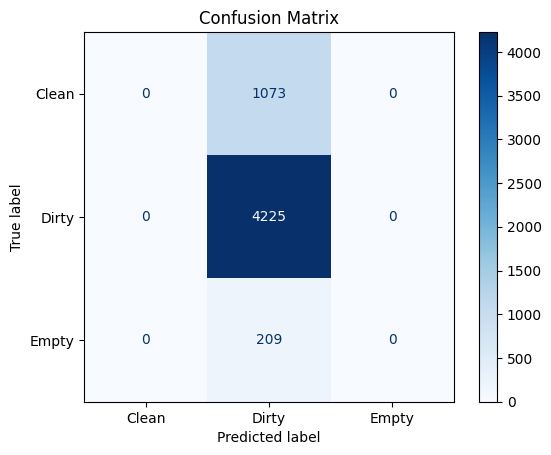

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds_list = []
labels_list = []
with torch.no_grad():
    for X, y in tqdm(val_loader): #Last Fold
        X, y = X.to(device=DEVICE), y.to(device=DEVICE)
        preds = model(X)
        _, preds = torch.max(preds, 1)

        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(y.cpu().numpy())

cm = confusion_matrix(labels_list, preds_list, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clean", "Dirty", "Empty"])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()